In [9]:
from pathlib import Path
import re
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
def load_texts(local_illiad: str = '../data/Homer_Illiad.txt',
               local_odyssey: str = '../data/Homer_Odyssey.txt') -> tuple[str, str]:
	"""Load Homer texts from disk.

	Parameters
	----------
	local_illiad : str
		Path to Iliad text file.
	local_odyssey : str
		Path to Odyssey text file.

	Returns
	-------
	tuple[str, str]
		(illiad_text, odyssey_text)
	"""
	p1, p2 = Path(local_illiad), Path(local_odyssey)

	if not p1.exists():
		raise FileNotFoundError(f"Missing file: {p1}")
	if not p2.exists():
		raise FileNotFoundError(f"Missing file: {p2}")

	illiad = p1.read_text(encoding='utf-8', errors='ignore')
	odyssey = p2.read_text(encoding='utf-8', errors='ignore')
	return illiad, odyssey

In [11]:
def extract_speeches(text: str) -> list[str]:
	"""
	Extract all quoted speeches from a literary text.

	Parameters
	----------
	text : str
		The full text of a literary work (e.g., *The Iliad*).

	Returns
	-------
	list[str]
		A list of strings, where each string represents one speech
		found inside quotation marks.

	Notes
	-----
	- The regex captures any text between pairs of quotation marks
	  such as "..." or “...”.
	- DOTALL mode allows matches that span multiple lines.
	- This method assumes that dialogues are consistently enclosed
	  in quotes. For editions that use different conventions (like
	  single quotes ‘...’), the pattern can be extended easily.
	"""
	matches = re.findall(r'[“"](.+?)[”"]', text, flags=re.DOTALL)
	return matches


def analyze_speeches(text: str) -> tuple[int, float]:
	"""
	Analyze a literary text to quantify dialogue characteristics.

	Parameters
	----------
	text : str
		The full text of a book or document.

	Returns
	-------
	tuple[int, float]
		(number_of_speeches, average_speech_length_in_words)

	Notes
	-----
	- Extracts all quoted segments via `extract_speeches()`.
	- Splits each speech into words to determine length.
	- Computes the average speech length (in words) using `statistics.mean`.
	- Returns (0, 0.0) if no speeches are found to avoid ZeroDivisionError.
	"""
	speeches = extract_speeches(text)
	if not speeches:
		return 0, 0.0

	lengths = [len(s.split()) for s in speeches]
	avg_len = mean(lengths)
	return len(speeches), avg_len

def get_speech_lengths(text: str) -> list[int]:
	"""
	Return a list of word counts for all speeches in a text.

	Parameters
	----------
	text : str
		The book text.

	Returns
	-------
	list[int]
		A list of integers representing the word count of each speech.
	"""
	speeches = extract_speeches(text)
	return [len(s.split()) for s in speeches]


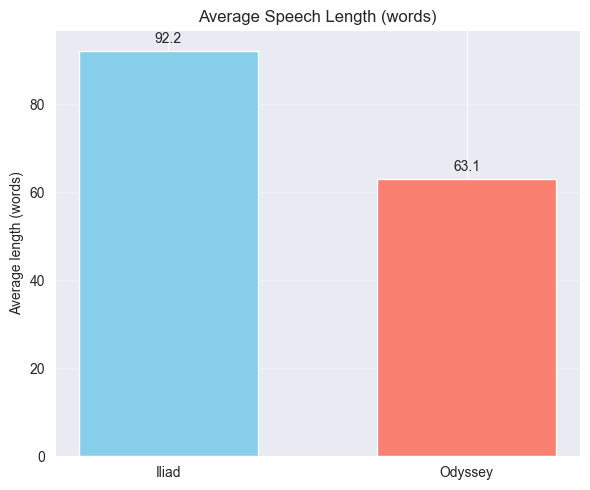

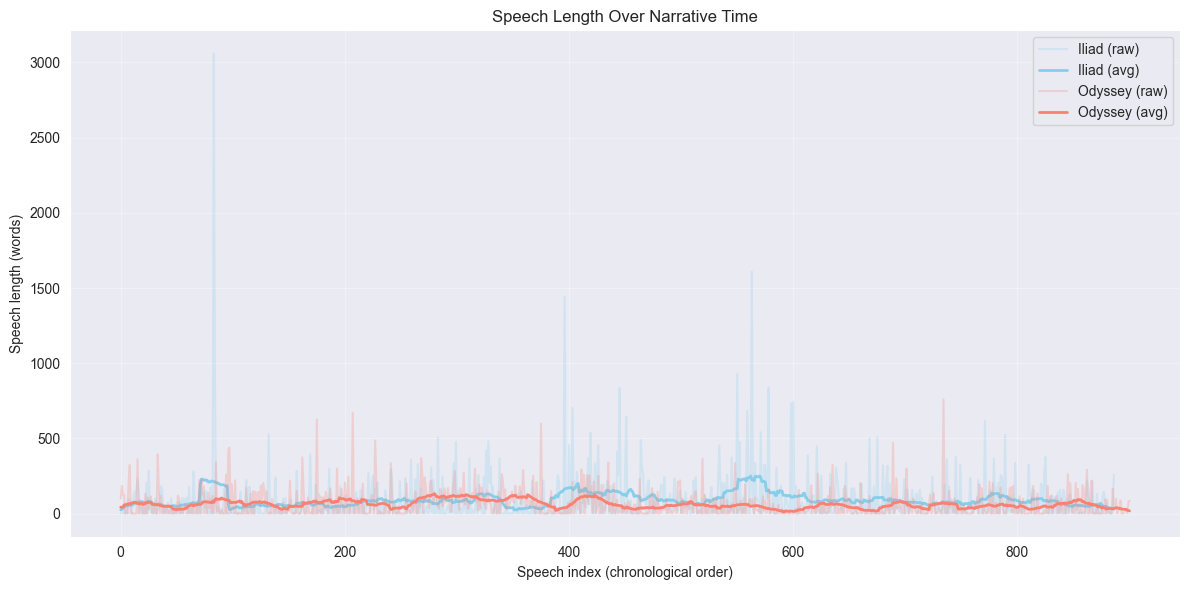

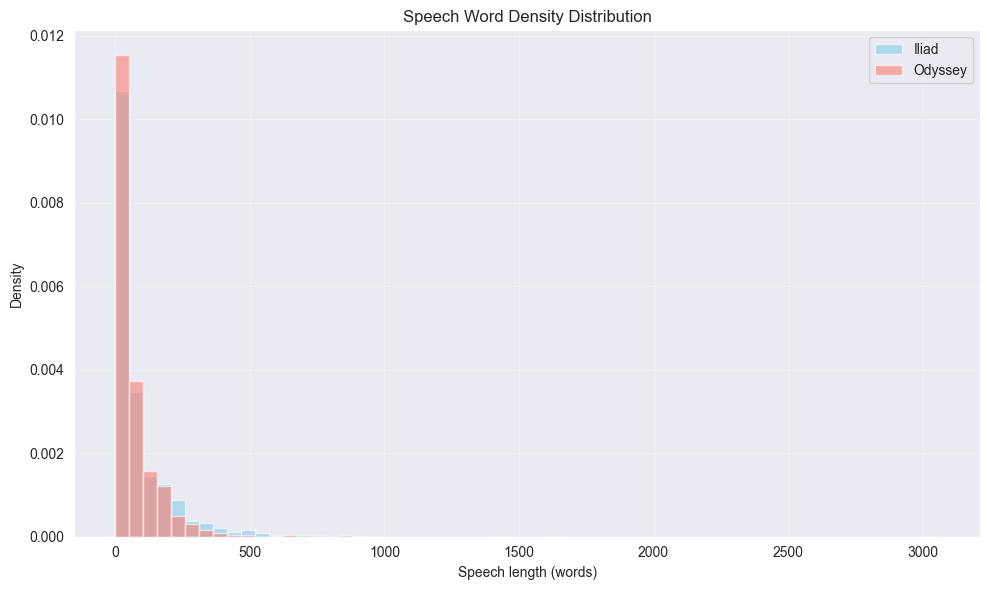

In [12]:
# 1) Load texts
illiad_text, odyssey_text = load_texts()

# 2) Get speech lengths (in words)
illiad_speeches = extract_speeches(illiad_text)
odyssey_speeches = extract_speeches(odyssey_text)

illiad_lengths = np.array([len(s.split()) for s in illiad_speeches], dtype=int)
odyssey_lengths = np.array([len(s.split()) for s in odyssey_speeches], dtype=int)

# ------------------------------------------------------------
# Plot 1: Average speech length (bar chart)
# ------------------------------------------------------------
avg_illiad = illiad_lengths.mean() if illiad_lengths.size else 0
avg_odyssey = odyssey_lengths.mean() if odyssey_lengths.size else 0

plt.figure(figsize=(6, 5))
bars = plt.bar(["Iliad", "Odyssey"], [avg_illiad, avg_odyssey],
			   color=["skyblue", "salmon"], width=0.6)
plt.title("Average Speech Length (words)")
plt.ylabel("Average length (words)")
for bar, val in zip(bars, [avg_illiad, avg_odyssey]):
	plt.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}",
			 ha="center", va="bottom")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig("avg_speech_length.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# Plot 2: Speech length over narrative time
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))

def smooth(y, window=25):
	if y.size == 0:
		return y
	w = max(1, min(window, y.size))
	kernel = np.ones(w) / w
	return np.convolve(y, kernel, mode="same")

if illiad_lengths.size:
	plt.plot(illiad_lengths, alpha=0.25, color="skyblue", label="Iliad (raw)")
	plt.plot(smooth(illiad_lengths, 25), linewidth=2, color="skyblue", label="Iliad (avg)")
if odyssey_lengths.size:
	plt.plot(odyssey_lengths, alpha=0.25, color="salmon", label="Odyssey (raw)")
	plt.plot(smooth(odyssey_lengths, 25), linewidth=2, color="salmon", label="Odyssey (avg)")

plt.xlabel("Speech index (chronological order)")
plt.ylabel("Speech length (words)")
plt.title("Speech Length Over Narrative Time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("speech_over_time.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# Plot 3: Speech word density distribution (clean histogram)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
max_len = max(illiad_lengths.max() if illiad_lengths.size else 1,
			  odyssey_lengths.max() if odyssey_lengths.size else 1)
bins = np.linspace(0, max_len, 60)  # fewer bins = readable

plt.hist(illiad_lengths, bins=bins, density=True, alpha=0.6, color="skyblue", label="Iliad")
plt.hist(odyssey_lengths, bins=bins, density=True, alpha=0.6, color="salmon", label="Odyssey")
plt.xlabel("Speech length (words)")
plt.ylabel("Density")
plt.title("Speech Word Density Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("speech_density_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
